# COMPREHENSIVE GUIDE TO HYPERPARAMETER TUNING
[Vikum Wijesinghe](https://www.linkedin.com/in/vikumwijesinghe/) - September 2019

Other Kernels: https://www.kaggle.com/vikumsw/kernels

---

# Problem Description

## There is an <font color="NAVY">ANGRY BABY</font>. What <font color="NAVY">FLAVOR</font> of <font color="NAVY">ICE CREAM</font> would you think is the best to make the baby pleased?

|||
|:-:|:-:|
|![](https://media.giphy.com/media/26gsnlYjswkyY3ENq/giphy.gif)|![](https://media.giphy.com/media/HuAvEGGh9o8rC/giphy.gif)|

## Analogy:
### * Angry Baby   -> Problem
### * Ice Cream    -> Choosen ML Algorithm to solve the problem
### * Flavors      -> Configurations/Properties of the ML Algorithm



## How are you going to solve the problem?
### 1. Choose the most popular flavor :-> <font color="GRAY">Using your Machine Learning algorithm with default hyperparameters, You would most likely end up with a suboptimal model.</font>
### 2. Choose the flavor baby likes the most :-> <font color="GRAY">Tuning your models Hyperparameters to get the most skillful model.</font>


Keep Reading to find out how to choose the flavor baby likes the most

# Table Of Contents

1. [What are hyperparameters?]()
1. [Some examples of hyperparameters]()
1. [Why they are important?]()
1. [How to tune hyperparamters]()
1. [Library import & Data Loading]()
1. [Quick Data Cleaning & Missing Values Handling](#)
1. [Helper Functions](#)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
from IPython.display import Image

train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv',index_col='Id') 
test  = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv',index_col='Id')

In [2]:
train.shape

(1460, 80)

In [3]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Helper Functions

In [4]:
def dropDataMissingColumns(df,percentage):
    print("Dropping columns where more than {}% values are Missing..".format(percentage))
    nan_percentage = df.isnull().sum().sort_values(ascending=False) / df.shape[0]
    missing_val = nan_percentage[nan_percentage > 0]
    to_drop = missing_val[missing_val > percentage/100].index.values
    df.drop(to_drop, axis=1, inplace=True)
    
def dropTargetMissingRows(df,target):
    print("Dropping Rows where Target is Missing..")
    df.dropna(axis=0, subset=[target], inplace=True)

def fillMissingValues(df):
    print("Filling MissingValues: object cols=""UNKOWN"" , Numeric cols=median..")
    # for Object columns fill using 'UNKOWN'
    # for Numeric columns fill using median
    num_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
    cat_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
    values = {}
    for a in cat_cols:
        values[a] = 'UNKOWN'

    for a in num_cols:
        values[a] = df[a].median()
        
    df.fillna(value=values,inplace=True)

def performOneHotEncoding(df,columnsToEncode):
    return pd.get_dummies(df,columns = columnsToEncode)    

def getObjectColumnsList(df):
    return [cname for cname in df.columns if df[cname].dtype == "object"]

def encodeCatFeatures(df,catColsToEncode):
    print("Encoding Categorical Features..")
    df = performOneHotEncoding(df,catColsToEncode)
    return df
    
def quickPreprocessData(df,target,catColsToEncode):
    print("QuickPreprocessData Started..")
    dropTargetMissingRows(df,target)
    fillMissingValues(df)
    df = encodeCatFeatures(df,catColsToEncode)
    print("QuickPreprocessData Completed")
    return df

def checkDataBeforeTraining(df):
    if(df.isnull().sum().sum() != 0):
        print("Error : Null Values Exist in Data")
        return False;
    
    if(len([cname for cname in df.columns if df[cname].dtype == "object"])>0):
        print("Error : Object Columns Exist in Data")
        return False;
    
    print("Data is Ready for Training")
    return True;

def getTrainX_TrainY(train,target):
    trainY = train.loc[:,target]
    trainX = train.drop(target, axis=1)
    return trainX,trainY

### Quick Data Cleaning & Missing Values Handling

In [5]:
dropTargetMissingRows(train,'SalePrice')
trainX,trainY = getTrainX_TrainY(train,'SalePrice')
dropDataMissingColumns(trainX,10)
fillMissingValues(trainX)
catColsToEncode = getObjectColumnsList(trainX)
trainX = encodeCatFeatures(trainX,catColsToEncode)

if(checkDataBeforeTraining(trainX) == False):
    sys.exit()

Dropping Rows where Target is Missing..
Dropping columns where more than 10% values are Missing..
Filling MissingValues: object cols=UNKOWN , Numeric cols=median..
Encoding Categorical Features..
Data is Ready for Training


## What are hyperparameters?

Let's create a Random Forest Regressor model for demonstration,

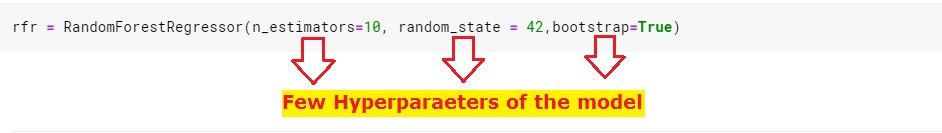

In [6]:
Image("../input/notebookimages/hy.PNG")

These parameters express configurations of the model such as its structure or learning rates. They are called hyperparameters.
These values cannot be estimated from data. So hyperparameters are usually set before training. Think of it like there exist different flavors of the same machine learning algorithm.

![](https://media.giphy.com/media/QmKtZGQn4cNi6EC15Y/giphy.gif)

## Some examples of hyperparameters :
* Number of leaves or depth of a tree
* Learning rate
* Number of hidden layers in a deep neural network
* Number of clusters in a k-means clustering

## Why they are important?.

In addition to choosing the best suited Machine Learning model for a particular problem, selecting the best falvour of the selected model also decides the performance.

### Predictive Modelling

Now Data is ready for training... First we need a regressor ... lets choose RandomForestRegressor...
Can't we just call .fit and get the model trainined?. -> yes we can... like below.

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from pprint import pprint

X, y = make_regression(n_features=4, n_informative=2,random_state=0, shuffle=False)
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X, y) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

But is this model tuned to this specific problem? . The answer is no!.
This is where hyperparameters come in to play.

Hyperparameter tuning is the way we tune a algorithm to a specific dataset to get a better skillful model. 


Lets see the current model.

In [8]:
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [9]:

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

def mean_squared_error_(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions) ** 0.5

RMSE = make_scorer(mean_squared_error_, greater_is_better=False)

rfr = RandomForestRegressor(n_jobs=1, random_state=0)
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100],
    'max_features': ['auto'],
    'min_samples_leaf': [2],
    'min_samples_split': [5],
    'n_estimators': [200, 2000]}
'''
model = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=-1, cv=10, scoring=RMSE, verbose=2)
model.fit(trainX, trainY)
score = -model.best_score_

print('Random forecast regression...')
print(rfr)
print('Best Params:\n', model.best_params_)
print('Best CV Score:', score)

#y_pred = model.predict(X_test)
'''

"\nmodel = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=-1, cv=10, scoring=RMSE, verbose=2)\nmodel.fit(trainX, trainY)\nscore = -model.best_score_\n\nprint('Random forecast regression...')\nprint(rfr)\nprint('Best Params:\n', model.best_params_)\nprint('Best CV Score:', score)\n\n#y_pred = model.predict(X_test)\n"

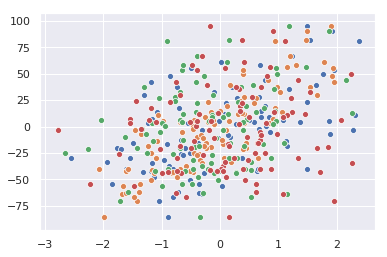

In [10]:
from sklearn.datasets import make_regression
import seaborn as sns; sns.set()
#import matplotlib.pyplot as plt

X, y = make_regression(n_features=4, n_informative=2,random_state=0, shuffle=False)

X.shape
y.shape

ax = sns.scatterplot(x=X[:,0], y=y)
ax = sns.scatterplot(x=X[:,1], y=y)
ax = sns.scatterplot(x=X[:,2], y=y)
ax = sns.scatterplot(x=X[:,3], y=y)